# Dataset exploration
In this notebook, I explore the dataset for use in the methods section of the paper.

## Setup

In [1]:
import glob
import json
import os
import sys
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from pytorch_lightning import seed_everything

config = json.load(open('/Users/emiliolr/Desktop/counting-cranes/config.json', 'r'))
CODE_FP = config['code_filepath_local']
DATA_FP = config['data_filepath_local']
SEED = config['random_seed']

sys.path.append(os.path.join(CODE_FP))

from utils import *

## Checking distribution of data across AGL

In [25]:
#A function to sort the data into our the closest (via absolute distance) AGL "bin" that we flew
def sort_AGL(observed_AGL):
    AGL_bins = np.array([2000, 2500, 3000, 3500, 4000, 4500, 5000])
    abs_dists = np.absolute(AGL_bins - observed_AGL)
    
    return AGL_bins[np.argmin(abs_dists)]

#A function to get the number of bboxes for a given image from our DF
def get_num_bboxes(image_name):
    relative_fp = image_name.upper().replace('.TIF', '.xml')
    full_fp = os.path.join(DATA_FP, 'annotations', relative_fp)

    return get_regression(get_bboxes(full_fp))

In [3]:
#Bringing in the metadata files
metadata_1 = pd.read_csv('~/Desktop/Conservation Research/processed_imagery/20210321_193700_metadata.csv')
metadata_2 = pd.read_csv('~/Desktop/Conservation Research/processed_imagery/20210321_213000_metadata_FLIR1 CAM1.csv')
metadata_3 = pd.read_csv('~/Desktop/Conservation Research/processed_imagery/20210321_224200_metadata_FLIR1 CAM1.csv')
metadata_4 = pd.read_csv('~/Desktop/Conservation Research/processed_imagery/20210321_213000_metadata_FLIR2 CAM1.csv')
metadata_5 = pd.read_csv('~/Desktop/Conservation Research/processed_imagery/20210321_224200_metadata_FLIR2 CAM1.csv')

#  putting everything into one DF
metadata = metadata_1.append(metadata_2, ignore_index = True).append(metadata_3, ignore_index = True).append(metadata_4, ignore_index = True).append(metadata_5, ignore_index = True)
print(metadata.shape)
metadata.head()

(9396, 8)


,Image_ID,GPS_Time,Lat,Long,Altitude_m,Omega,Phi,Kappa
0,FLIR1_20210321_195952_642_1676.tif,90009.003270,40.960730,-98.316897,538.292011,0.025342,5.726347,179.7264
1,FLIR1_20210321_195953_641_1677.tif,90010.004260,40.960671,-98.316898,538.287711,-0.007181,5.765818,179.3759
2,FLIR1_20210321_195954_635_1678.tif,90011.005727,40.960612,-98.316898,538.278688,0.025365,5.850090,179.1179
3,FLIR1_20210321_195955_637_1679.tif,90012.006721,40.960553,-98.316898,538.277663,-0.026031,5.821187,179.1726
4,FLIR1_20210321_195956_640_1680.tif,90013.002205,40.960493,-98.316898,538.277586,-0.053063,5.799220,179.2741


In [4]:
#Grabbing the image and annotation filepaths
image_fps = sorted(os.listdir(os.path.join(DATA_FP, 'images')))
annotation_fps = sorted(os.listdir(os.path.join(DATA_FP, 'annotations')))
print(f'We have {len(image_fps)} images and {len(annotation_fps)} annotation files')

We have 34 images and 34 annotation files


In [5]:
#Grabbing out the metadata for our images - only can grab metadata for 2021 images
fps_uppercase = [fp.upper() for fp in image_fps]
image_metadata = metadata[metadata['Image_ID'].str.upper().isin(fps_uppercase)]
image_metadata;

In [6]:
#Which images do we not have metadata for?
have_metadata = image_metadata['Image_ID'].to_numpy()
have_metadata = [fp.replace('tif', 'TIF') for fp in have_metadata]
have_metadata
np.setdiff1d(image_fps, have_metadata)

array(['20180320_212957_600_9151.tif', '20180320_212958_600_9152.tif',
       '20180321_220440_395_1832.tif', '20180321_223203_097_2805.tif',
       '20180321_223204_097_2806.tif', '20180321_223215_097_2817.tif',
       '20180321_223216_097_2818.tif',
       'FLIR2_20210321_201851_358_2510.TIF'], dtype='<U34')

In [7]:
#Manually adding the flight heights for those that are missing
image_metadata = image_metadata[['Image_ID', 'Altitude_m']].copy()

image_metadata = image_metadata.append({'Image_ID' : 'FLIR2_20210321_201851_358_2510.TIF',
                                        'Altitude_m' : 1653.5}, ignore_index = True) #grabbed this from the surrounding images in metadata file

#  2018 metadata is in the folder name, so I just went back and relocated these in their folders
image_metadata = image_metadata.append({'Image_ID' : '20180321_220440_395_1832.tif',
                                        'Altitude_m' : 1819.14}, ignore_index = True)
image_metadata = image_metadata.append({'Image_ID' : '20180321_223203_097_2805.tif',
                                        'Altitude_m' : 1819.14}, ignore_index = True)
image_metadata = image_metadata.append({'Image_ID' : '20180321_223204_097_2806.tif',
                                        'Altitude_m' : 1819.14}, ignore_index = True)
image_metadata = image_metadata.append({'Image_ID' : '20180321_223215_097_2817.tif',
                                        'Altitude_m' : 1819.14}, ignore_index = True)
image_metadata = image_metadata.append({'Image_ID' : '20180321_223216_097_2818.tif',
                                        'Altitude_m' : 1819.14}, ignore_index = True)
image_metadata = image_metadata.append({'Image_ID' : '20180320_212957_600_9151.tif',
                                        'Altitude_m' : 2123.92}, ignore_index = True)
image_metadata = image_metadata.append({'Image_ID' : '20180320_212958_600_9152.tif',
                                        'Altitude_m' : 2123.92}, ignore_index = True)

In [29]:
#Adding in the number of bboxes for each image in the dataset
image_metadata['num_bboxes'] = image_metadata['Image_ID'].apply(get_num_bboxes)

image_metadata.head()

,Image_ID,Altitude_m,num_bboxes
0,FLIR2_20210321_204704_024_4313.tif,1352.841234,2044
1,FLIR2_20210321_205849_352_4973.tif,1353.264701,1360
2,FLIR2_20210321_205850_355_4974.tif,1353.090688,1745
3,FLIR2_20210321_212531_852_5634.tif,1221.399421,1818
4,FLIR2_20210321_212535_841_5638.tif,1220.768652,1426


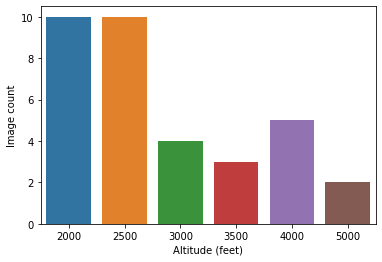

In [8]:
#Looking at the distribution of heights in the FULL dataset
AGLs_feet = (image_metadata['Altitude_m'] - 600) * 3.281 #converting from above sea level to AGL in meters, then converting to feet
sorted_AGLs = AGLs_feet.apply(sort_AGL)
sns.countplot(x = sorted_AGLs)
plt.xlabel('Altitude (feet)')
plt.ylabel('Image count');

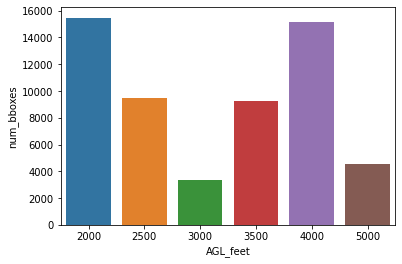

In [36]:
#How many annotated bboxes at each height in the full dataset?
image_metadata['AGL_feet'] = sorted_AGLs
bboxes_by_AGL = image_metadata.groupby('AGL_feet').sum()['num_bboxes']

sns.barplot(x = bboxes_by_AGL.index, y = bboxes_by_AGL);

Global seed set to 1693


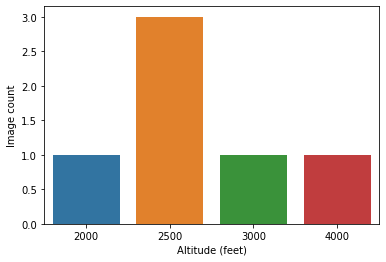

In [41]:
#Checking distribution of heights in the test set
seed_everything(SEED)
indices = torch.randperm(len(image_fps)).tolist()
test_indices = indices[28 : ]
test_images = list(np.array(image_fps)[test_indices])

test_metadata = image_metadata[image_metadata['Image_ID'].str.upper().isin([fp.upper() for fp in test_images])]
test_AGL_feet = (test_metadata['Altitude_m'] - 600) * 3.281
test_AGL_sorted = test_AGL_feet.apply(sort_AGL)
sns.countplot(x = test_AGL_sorted)
plt.xlabel('Altitude (feet)')
plt.ylabel('Image count');

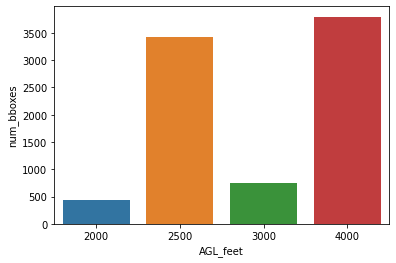

In [43]:
#Checking the number of bboxes at each height in the test set
test_bboxes_by_AGL = test_metadata.groupby('AGL_feet').sum()['num_bboxes']

sns.barplot(x = test_bboxes_by_AGL.index, y = test_bboxes_by_AGL);

In [53]:
#Saving the transformed metadata file for use in later figures (in R instead of Python)
tweaked_metadata_df = image_metadata.drop('Altitude_m', axis = 1)
tweaked_metadata_df['Image_ID'] = tweaked_metadata_df['Image_ID'].apply(lambda fp: fp.upper() if fp.startswith('FLIR2') else fp)
tweaked_metadata_df.to_csv(os.path.join(DATA_FP, 'dataset_metadata.csv'))